# Main results from subnational P budget calculation for EU28

This notebook loads and compiles the results from the other parts of the calculation.

In [1]:
import os
import pandas as pd
import nuts
import settings

In [2]:
nuts_table = nuts.get_nuts_candidates()
EU28_countries = list(nuts_table.country_code.unique())

In [3]:
refareas = pd.read_csv(settings.REFERENCE_AREAS_PATH, index_col='geo')
refareas

,UAA,UAA_XJ2000_J3000
geo,,
AT,2.72689,2.28822
AT1,1.09884,1.08506
AT11,0.18197,0.17671
AT12,0.90885,0.90100
AT13,0.00802,0.00735
...,...,...
UKM3,0.79834,0.48694
UKM5,0.47877,0.31144
UKM6,2.76356,0.43391


In [4]:
harvest = pd.read_csv(settings.HARVEST_PATH, index_col='geo')
harvest

,UAA,UAA_XJ2000_J3000
geo,,
AT,35.538532,31.720921
AT1,15.796516,15.697578
AT11,2.391751,2.361472
AT12,13.859568,13.798137
AT13,0.095626,0.093916
...,...,...
UKM3,14.974345,9.147147
UKM5,8.888009,5.764010
UKM6,51.809166,8.105715


In [5]:
excretion = pd.read_csv(settings.EXCRETION_PATH, index_col='geo').excretion
excretion

geo
AT      27.834650
AT11     0.395425
AT12     6.347312
AT13     0.002201
AT21     2.369130
          ...    
UKM2    10.211552
UKM3    11.429717
UKM5     4.001366
UKM6     6.979625
UKN0    23.973491
Name: excretion, Length: 286, dtype: float64

In [6]:
mineral = pd.read_csv(settings.MINERAL_FERTILIZER_PATH, index_col='geo').mineral
mineral

geo
AT      17.261000
AT1      6.955574
AT11     1.341108
AT12     7.996930
AT13     0.050766
          ...    
UKM3     3.771635
UKM5     2.261876
UKM6    13.056016
UKN      2.735834
UKN0     2.735834
Name: mineral, Length: 390, dtype: float64

# Gather quantities for refarea alternatives and calculate surplus

In [7]:
quantities_all = {
    k: (
        pd.DataFrame(
            dict(
                harvest=harvest[k],
                excretion=excretion,
                mineral=mineral,
                refarea=refareas[k],
            )
        )
        .assign(surplus=lambda d:d.eval('excretion + mineral - harvest'))
        [['harvest', 'excretion', 'mineral', 'surplus', 'refarea']]
        .reindex(nuts_table.index)
    )
    for k in refareas.columns
}
quantities_all

{'UAA':         harvest  excretion    mineral    surplus  refarea
 geo                                                      
 AT    35.538532  27.834650  17.261000   9.557118  2.72689
 AT1   15.796516        NaN   6.955574        NaN  1.09884
 AT11   2.391751   0.395425   1.341108  -0.655218  0.18197
 AT12  13.859568   6.347312   7.996930   0.484674  0.90885
 AT13   0.095626   0.002201   0.050766  -0.042659  0.00802
 ...         ...        ...        ...        ...      ...
 UKM3  14.974345  11.429717   3.771635   0.227007  0.79834
 UKM5   8.888009   4.001366   2.261876  -2.624768  0.47877
 UKM6  51.809166   6.979625  13.056016 -31.773524  2.76356
 UKN   19.629553        NaN   2.735834        NaN  1.04614
 UKN0  19.629553  23.973491   2.735834   7.079772  1.04614
 
 [390 rows x 5 columns],
 'UAA_XJ2000_J3000':         harvest  excretion    mineral    surplus  refarea
 geo                                                      
 AT    31.720921  27.834650  17.261000  13.374729  2.28822
 A

# Calculate rates (quantity / refarea)

In [8]:
rates_all = {
    k: v.div(v["refarea"], axis=0).drop(columns="refarea").join(v["refarea"])
    for k, v in quantities_all.items()
}
rates_all

{'UAA':         harvest  excretion   mineral    surplus  refarea
 geo                                                     
 AT    13.032624  10.207471  6.329922   3.504769  2.72689
 AT1   14.375629        NaN  6.329924        NaN  1.09884
 AT11  13.143653   2.173025  7.369938  -3.600691  0.18197
 AT12  15.249565   6.983894  8.798954   0.533283  0.90885
 AT13  11.923475   0.274447  6.329915  -5.319113  0.00802
 ...         ...        ...       ...        ...      ...
 UKM3  18.756851  14.316853  4.724347   0.284349  0.79834
 UKM5  18.564257   8.357596  4.724347  -5.482315  0.47877
 UKM6  18.747256   2.525592  4.724347 -11.497317  2.76356
 UKN   18.763791        NaN  2.615170        NaN  1.04614
 UKN0  18.763791  22.916140  2.615170   6.767519  1.04614
 
 [390 rows x 5 columns],
 'UAA_XJ2000_J3000':         harvest  excretion    mineral    surplus  refarea
 geo                                                      
 AT    13.862706  12.164324   7.543418   5.845036  2.28822
 AT1   14.46701

# Compare national surplus calculated on different NUTS levels

If the data are consistent and have sufficiently high coverage, the results should agree rather closely but need not be exactly identical.

In [9]:
def calculate_national_surplus_rates(quantities):
    return (
        pd.DataFrame(
            {
                nuts_level: (
                    quantities
                    .pipe(nuts.filter_nuts_level, nuts_level)
                    [['surplus', 'refarea']]
                    .dropna()
                    .join(nuts_table.country_code, how='inner')
                    .groupby('country_code')
                    .sum()
                    .eval('surplus / refarea')
                )
                for nuts_level in [0, 1, 2]
            }
        )
    )

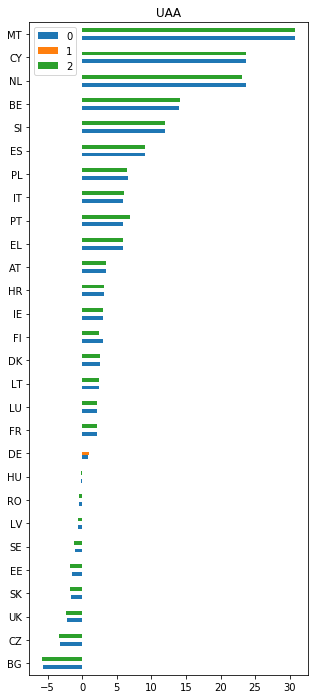

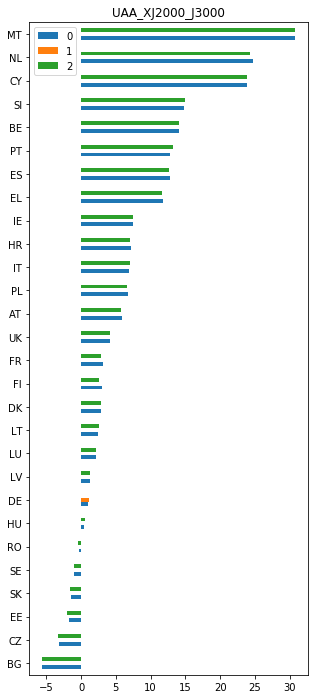

In [10]:
for variant, q in quantities_all.items():
    ax = (
        calculate_national_surplus_rates(q)
        .sort_values(0)
        .plot
        .barh(figsize=(5, 12))
    )
    ax.set_title(variant)

# Select NUTS level to use for each country

In [11]:
selected_nuts_level = (
    pd.Series(
        {
            **{k: 2 for k in EU28_countries},
            **{'DE': 1}, # exceptions
        },
    )
    .rename_axis('country_code')
    .rename('nuts_level')
)

selected_regions = (
    nuts_table
    .reset_index()
    .merge(selected_nuts_level.reset_index(), on=['country_code', 'nuts_level'], how='inner')
    .set_index('geo')
    .index
)
selected_regions

def get_selected_subset(d, level=None):
    return d.reindex(selected_regions, level=level)

In [12]:
selected_regions

Index(['AT11', 'AT12', 'AT13', 'AT21', 'AT22', 'AT31', 'AT32', 'AT33', 'AT34',
       'BE10',
       ...
       'UKK2', 'UKK3', 'UKK4', 'UKL1', 'UKL2', 'UKM2', 'UKM3', 'UKM5', 'UKM6',
       'UKN0'],
      dtype='object', name='geo', length=243)

In [13]:
subnational_quantities = {
    k: v.pipe(get_selected_subset)
    for k, v in quantities_all.items()
}

subnational_rates = {
    k: v.pipe(get_selected_subset)
    for k, v in rates_all.items()
}

In [14]:
national_quantities = {
    k: v.join(nuts_table.country_code).groupby('country_code').sum().rename_axis('geo', axis=0)
    for k, v in subnational_quantities.items()
}

national_rates = {
    k: v.div(v.refarea, axis=0).drop(columns='refarea').join(v.refarea)
    for k, v in national_quantities.items()
}

In [15]:
df.to_csv?

Object `df.to_csv` not found.


In [16]:
names_to_save = [
    'subnational_quantities',
    'subnational_rates',
    'national_quantities',
    'national_rates',
]

for name in names_to_save:
    value = vars()[name]
    for refarea, df in value.items():
        os.makedirs(f'outdata/{refarea}', exist_ok=True)
        df.to_csv(f'outdata/{refarea}/{name}.csv', float_format='%.4f')